In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, classification_report, accuracy_score, log_loss
import xgboost as xgb
import scipy
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
train = pd.read_csv('qp_data/X_train.csv')

In [3]:
y_train = train['is_duplicate'].values

In [4]:
y_train[:100]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [5]:
X_train =train.drop('is_duplicate', axis=1,)

In [6]:
X_train.columns.values

array(['word_match', 'tfidf_wm', 'tfidf_wm_stops', 'jaccard', 'wc_diff',
       'wc_ratio', 'wc_diff_unique', 'wc_ratio_unique',
       'wc_diff_unq_stop', 'wc_ratio_unique_stop', 'same_start',
       'char_diff', 'char_diff_unq_stop', 'common_words',
       'total_unique_words', 'total_unq_words_stop', 'char_ratio',
       'len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2',
       'len_word_q1', 'len_word_q2', 'common_words.1', 'fuzz_qratio',
       'fuzz_WRatio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd',
       'cosine_distance', 'cityblock_distance', 'canberra_distance',
       'minkowski_distance', 'braycurtis_distance', 'skew_q1vec',
       'skew_q2vec', 'kur_q1vec', 'q1_q2_intersect', 'q1_freq', 'q2_freq'],
      dtype=object)

In [7]:
X_train.shape

(404290, 45)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=4242)

In [9]:
X_train.shape

(363861, 45)

In [10]:
X_train.head()

,word_match,tfidf_wm,tfidf_wm_stops,jaccard,wc_diff,wc_ratio,wc_diff_unique,wc_ratio_unique,wc_diff_unq_stop,wc_ratio_unique_stop,...,cityblock_distance,canberra_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,q1_q2_intersect,q1_freq,q2_freq
229090,0.750000,0.706577,0.730434,0.500000,1,0.875,1,0.875,2,0.600000,...,7.840840,127.005896,0.254952,0.292590,-0.073095,-0.106657,-0.415193,1,3,2
18027,0.666667,0.666972,0.737261,0.333333,0,1.000,0,1.000,0,1.000000,...,8.170552,128.155678,0.260511,0.303738,0.067811,0.147733,-0.080394,4,6,8
120688,0.695652,0.763476,0.713954,0.681818,1,0.950,3,0.850,3,0.769231,...,8.457547,131.021706,0.266438,0.315307,0.047875,0.141016,-0.094543,0,2,1
272940,0.545455,0.502982,0.573567,0.400000,5,1.625,5,1.625,3,1.750000,...,5.927663,98.602686,0.195784,0.214771,-0.100558,-0.134806,-0.396855,0,9,8
226468,0.800000,0.987288,1.000000,0.750000,2,0.750,2,0.750,1,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.230799,0.230799,-0.315706,0,2,3


In [11]:
pos_train = X_train[y_train == 1]
neg_train = X_train[y_train == 0]
X_train = pd.concat((neg_train, pos_train.iloc[:int(0.8*len(pos_train))], neg_train))
y_train = np.array([0] * neg_train.shape[0] + [1] * pos_train.iloc[:int(0.8*len(pos_train))].shape[0] + [0] * neg_train.shape[0])
print(np.mean(y_train))
del pos_train, neg_train

0.18975293212164862


In [12]:
pos_valid = X_valid[y_valid == 1]
neg_valid = X_valid[y_valid == 0]
X_valid = pd.concat((neg_valid, pos_valid.iloc[:int(0.8 * len(pos_valid))], neg_valid))
y_valid = np.array([0] * neg_valid.shape[0] + [1] * pos_valid.iloc[:int(0.8 * len(pos_valid))].shape[0] + [0] * neg_valid.shape[0])
print(np.mean(y_valid))
del pos_valid, neg_valid

0.18923467767545252


In [13]:
X_train.shape

(566484, 45)

In [14]:
y_train.shape

(566484,)

In [18]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 7
params['subsample'] = 0.6
params['base_score'] = 0.2
# params['scale_pos_weight'] = 0.2

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 2500, watchlist, early_stopping_rounds=50, verbose_eval=50)
print(log_loss(y_valid, bst.predict(d_valid)))

[0]	train-logloss:0.47543	valid-logloss:0.474788
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.2714	valid-logloss:0.273313
[100]	train-logloss:0.221714	valid-logloss:0.224774
[150]	train-logloss:0.204029	valid-logloss:0.207911
[200]	train-logloss:0.196353	valid-logloss:0.200878
[250]	train-logloss:0.191871	valid-logloss:0.197101
[300]	train-logloss:0.188169	valid-logloss:0.194071
[350]	train-logloss:0.184928	valid-logloss:0.19183
[400]	train-logloss:0.182368	valid-logloss:0.190371
[450]	train-logloss:0.180033	valid-logloss:0.189137
[500]	train-logloss:0.178061	valid-logloss:0.188247
[550]	train-logloss:0.176344	valid-logloss:0.187594
[600]	train-logloss:0.174781	valid-logloss:0.18699
[650]	train-logloss:0.173306	valid-logloss:0.186533
[700]	train-logloss:0.171841	valid-logloss:0.186087
[750]	train-logloss:0.170544	valid-logloss:0.185794
[800]	train-logloss:0.169

In [19]:
# bst.save_model('qp_data/xgb.model')

In [ ]:
print(log_loss(y_valid, bst.predict(d_valid)))

In [15]:
bst= xgb.Booster(model_file='qp_data/xgb.model')


In [16]:
X_test = pd.read_csv('qp_data/X_test.csv')

In [17]:
X_test.head()

,word_match,tfidf_wm,tfidf_wm_stops,jaccard,wc_diff,wc_ratio,wc_diff_unique,wc_ratio_unique,wc_diff_unq_stop,wc_ratio_unique_stop,...,cityblock_distance,canberra_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,q1_q2_intersect,q1_freq,q2_freq
0,0.266667,0.234251,0.274019,0.090909,3,1.272727,2,1.181818,3,1.500000,...,12.006720,164.254264,0.407153,0.483565,0.045990,0.009958,0.039938,0,1,1
1,0.500000,0.436043,0.480962,0.235294,7,0.500000,7,0.500000,2,0.714286,...,6.501658,115.512012,0.210239,0.245248,-0.017419,-0.046821,0.207580,0,2,2
2,0.444444,0.418727,0.468893,0.285714,8,0.428571,6,0.500000,3,0.500000,...,8.129246,125.626922,0.253134,0.299802,0.072835,-0.058206,-0.505310,0,1,1
3,0.000000,0.000000,0.000000,0.000000,1,0.750000,1,0.750000,0,1.000000,...,10.918439,159.496524,0.366312,0.438647,0.060417,0.069599,-0.241064,0,1,1
4,0.800000,0.841273,1.000000,0.428571,2,1.500000,2,1.500000,1,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.006085,0.006085,-0.081313,0,1,1


In [18]:
test = pd.read_csv('qp_data/test.csv')

In [19]:
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

In [20]:
sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = p_test

In [21]:
sub.head()

,test_id,is_duplicate
0,0,0.000101
1,1,0.146597
2,2,0.249101
3,3,0.000119
4,4,0.047839


In [22]:
sub.to_csv('qp_data/submission.csv',index = False)

In [19]:
import operator
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

print("Features importances...")
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])
print(importance)



Features importances...
[('f10', 951), ('f8', 958), ('f6', 1258), ('f4', 1345), ('f22', 1971), ('f13', 1996), ('f23', 2200), ('f19', 2299), ('f26', 2304), ('f38', 2554), ('f35', 2578), ('f9', 2729), ('f7', 2759), ('f5', 2773), ('f15', 2809), ('f14', 2863), ('f37', 3007), ('f11', 3235), ('f20', 3372), ('f21', 3375), ('f12', 3512), ('f34', 3863), ('f43', 4317), ('f0', 4320), ('f42', 4410), ('f36', 4675), ('f29', 4783), ('f30', 4785), ('f17', 4981), ('f25', 5057), ('f18', 5156), ('f31', 5186), ('f44', 5202), ('f16', 5214), ('f3', 6280), ('f27', 6375), ('f32', 6879), ('f33', 7551), ('f2', 8798), ('f40', 8954), ('f39', 9066), ('f41', 10019), ('f1', 10859)]


In [21]:
ft['feature']=ft['feature'].replace('\D+', '', regex=True).astype(int)

In [22]:
ft.shape

(43, 2)

In [24]:
name = X_train.columns.values

In [25]:
print(name[24])
name[28]

common_words.1


'fuzz_partial_token_set_ratio'

In [26]:
name = np.delete(name, [24,28])

In [27]:
name

array(['word_match', 'tfidf_wm', 'tfidf_wm_stops', 'jaccard', 'wc_diff',
       'wc_ratio', 'wc_diff_unique', 'wc_ratio_unique',
       'wc_diff_unq_stop', 'wc_ratio_unique_stop', 'same_start',
       'char_diff', 'char_diff_unq_stop', 'common_words',
       'total_unique_words', 'total_unq_words_stop', 'char_ratio',
       'len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2',
       'len_word_q1', 'len_word_q2', 'fuzz_qratio', 'fuzz_WRatio',
       'fuzz_partial_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd',
       'cosine_distance', 'cityblock_distance', 'canberra_distance',
       'minkowski_distance', 'braycurtis_distance', 'skew_q1vec',
       'skew_q2vec', 'kur_q1vec', 'q1_q2_intersect', 'q1_freq', 'q2_freq'],
      dtype=object)

In [28]:
ft.sort_values(by="feature" , ascending=True, inplace=True)

In [31]:
ft['feature'] = name
ft

,feature,fscore
23,word_match,4320
42,tfidf_wm,10859
38,tfidf_wm_stops,8798
34,jaccard,6280
3,wc_diff,1345
13,wc_ratio,2773
2,wc_diff_unique,1258
12,wc_ratio_unique,2759
1,wc_diff_unq_stop,958
11,wc_ratio_unique_stop,2729


In [36]:
ft.sort_values(by="fscore" , ascending=True, inplace=True)

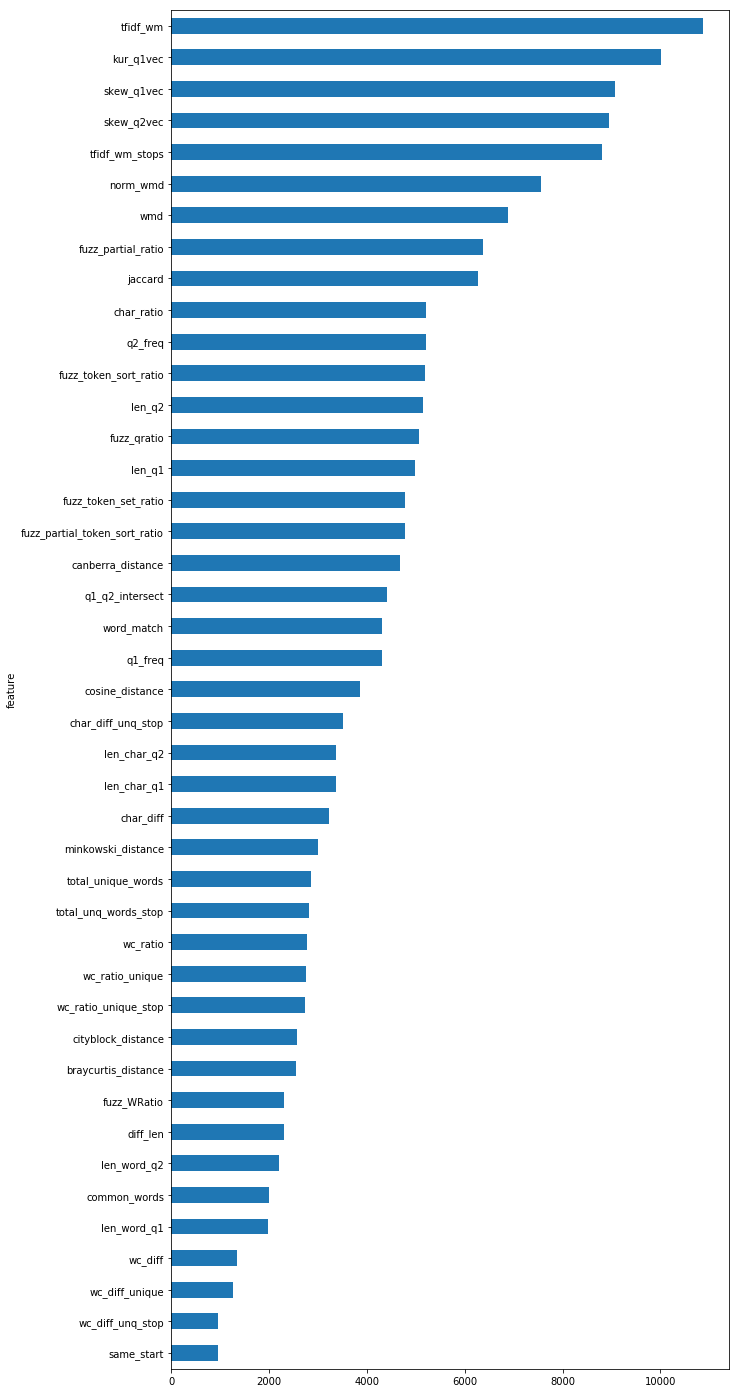

In [37]:
ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')